In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
# 会报警
# /home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
#  from IPython.utils import traitlets as _traitlets
from fastai.vision import *

from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = '1202_14-10-24'  # get_BJ_time()
print(current_time)

base_model_name = "efficientnet-b4_1202_14-10-24_stage1"  # 原来为 efficientnet-b4_0811_00-03-47_stage1

1203_16-38-41


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 16 #smaller batch size is better for training, but may take longer  # 显存不够，32改为16（24会崩，20以内不会）
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# Training (Transfer learning)
The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [7]:
# 加权kappa系数
# 当预测与真值都为一类时，cohen_kappa_score()会出现除0值的异常，因此取出源码特殊处理
def qk(y_pred, y):
    y1 = torch.round(y_pred)
    y2 = y
    labels=None
    weights='quadratic'
    sample_weight=None
    
    confusion = confusion_matrix(y1, y2, labels=labels,
                                 sample_weight=sample_weight)
    # print(confusion)
    n_classes = confusion.shape[0]
    if n_classes <= 1:
        # 特殊处理
        print('Both the predict and ground truth are the same and the only one class! set qk as 1.0')
        return torch.tensor(1., device='cuda:0')

    sum0 = np.sum(confusion, axis=0)
    sum1 = np.sum(confusion, axis=1)
    expected = np.outer(sum0, sum1) / np.sum(sum0)

    if weights is None:
        w_mat = np.ones([n_classes, n_classes], dtype=np.int)
        w_mat.flat[:: n_classes + 1] = 0
    elif weights == "linear" or weights == "quadratic":
        w_mat = np.zeros([n_classes, n_classes], dtype=np.int)
        w_mat += np.arange(n_classes)
        if weights == "linear":
            w_mat = np.abs(w_mat - w_mat.T)
        else:
            w_mat = (w_mat - w_mat.T) ** 2
    else:
        raise ValueError("Unknown kappa weighting type.")

    k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
    
    return torch.tensor(1 - k, device='cuda:0')
    
    # return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

## Fold 1

In [8]:
# test
# df_2019_cv.csv共有3662个样本，分五折
# is_valid1为true为第一折，共737个样本为true，其他2925样本为false
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid1")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

# sample_submission.csv共有1928个样本
learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);  # 原来为efficientnet-b4_0811_00-03-47_stage1 ;  #引号;隐藏命令的输出

Loaded pretrained weights for efficientnet-b4


Learner(data=ImageDataBunch;

Train: LabelList (2925 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: ../input/aptos2019-blindness-detection;

Valid: LabelList (737 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: ../input/aptos2019-blindness-detection;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ../input/aptos2019-blindness-detection, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleL

In [ ]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid1")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b4_0811_00-03-47_stage1");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


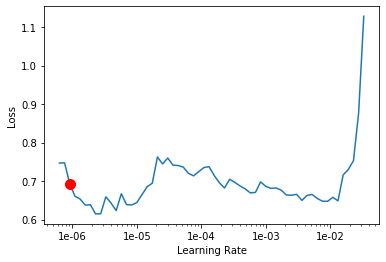

In [9]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find()  # 一轮182次（2925//16=182）
learn.recorder.plot(suggestion=True)

In [10]:
# test
model_save_name = "{}_{}_stage2_f1".format(model_name, current_time)
# learn.recorder.min_grad_lr当前为3.311311214825911e-06，训练loss大结果不理解，手动改为1e-03

# qk的计算出现很多nan值，
# /home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
#  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
# 1.减小学习率10倍，仍可能出现
# 2.升级scikit-learn模块 conda install scikit-learn=0.22，问题依旧
# 3.走查kappa源码，发现预测和真值全为同一类时，会出现分母为0的异常

# 测试发现每一代epoch后显示的qk值，为验证集每一轮计算的kappa值加权平均。

# min_grad_lr = learn.recorder.min_grad_lr
# 40epoch,每轮训练182次（2925/16=182.8125向下取整182），验证47次（737/16=46.0625向上取整47）
learn.fit_one_cycle(40, 1e-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.487214,0.416974,0.844873,02:10
1,0.403149,0.418145,0.864737,02:12
2,0.347244,0.382303,0.865980,02:12
3,0.334979,0.309039,0.874361,02:12
4,0.298437,0.339591,0.862118,02:11
5,0.284795,0.311270,0.867931,02:07
6,0.297164,0.312460,0.882745,02:07
7,0.292712,0.258465,0.882195,02:08
8,0.273927,0.261881,0.901799,02:08
9,0.276510,0.361392,0.861736,02:07


Better model found at epoch 0 with valid_loss value: 0.41697439551353455.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Better model found at epoch 2 with valid_loss value: 0.38230326771736145.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Better model found at epoch 3 with valid_loss value: 0.309039443731308.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Better model found at epoch 7 with valid_loss value: 0.25846487283706665.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and groun

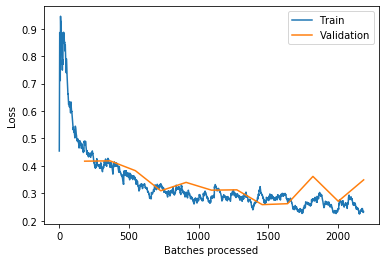

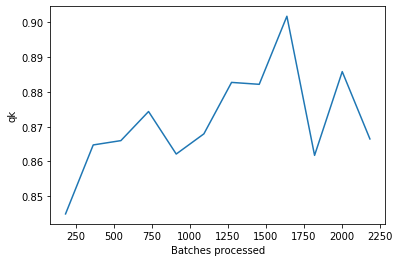

In [11]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [14]:
model_save_name = "{}_{}_stage2_f1".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.205075,0.218655,0.905854,00:31
1,0.196807,0.218488,0.904858,00:31
2,0.194677,0.218148,0.905352,00:31
3,0.191779,0.217927,0.905668,00:31
4,0.195264,0.217479,0.907087,00:32
5,0.198205,0.216817,0.906856,00:31
6,0.204561,0.216989,0.911001,00:31
7,0.198198,0.217086,0.910209,00:31
8,0.193785,0.217150,0.911375,00:31
9,0.190187,0.216499,0.912484,00:31


Better model found at epoch 0 with valid_loss value: 0.21865488588809967.
Better model found at epoch 1 with valid_loss value: 0.21848808228969574.
Better model found at epoch 2 with valid_loss value: 0.2181481271982193.
Better model found at epoch 3 with valid_loss value: 0.21792654693126678.
Better model found at epoch 4 with valid_loss value: 0.21747875213623047.
Better model found at epoch 5 with valid_loss value: 0.21681658923625946.
Better model found at epoch 9 with valid_loss value: 0.2164992094039917.
Better model found at epoch 11 with valid_loss value: 0.21582671999931335.
Better model found at epoch 12 with valid_loss value: 0.21553172171115875.
Better model found at epoch 13 with valid_loss value: 0.21543295681476593.
Better model found at epoch 14 with valid_loss value: 0.21523694694042206.
Epoch 18: early stopping
Model save as: efficientnet-b4_0820_01-09-57_stage2_f1


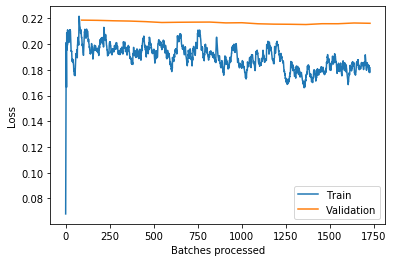

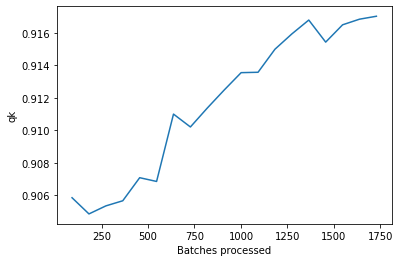

In [15]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [15]:
learn.load(model_save_name);  #引号;隐藏命令的输出

## Fold 2

In [16]:
# test
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid2")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);

Loaded pretrained weights for efficientnet-b4


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.25E-04


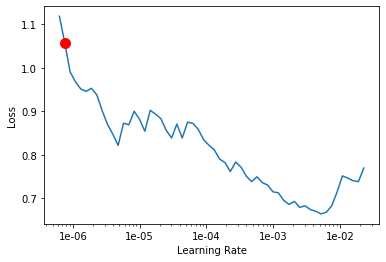

In [17]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.75E-05


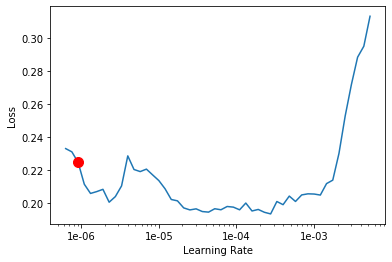

In [31]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [20]:
# test
model_save_name = "{}_{}_stage2_f2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
# 原学习率设为3e-6，太小，训练结果不好
learn.fit_one_cycle(40, 1e-3, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.505439,0.332587,0.843380,02:07
1,0.395855,0.326306,0.857659,02:08
2,0.330762,0.285215,0.865530,02:08
3,0.324024,0.269608,0.881490,02:08
4,0.308399,0.258782,0.881235,02:11
5,0.329289,0.249224,0.871168,02:13
6,0.279736,0.245598,0.886290,02:12
7,0.258765,0.298856,0.866891,02:12
8,0.310275,0.279332,0.870095,02:11
9,0.270353,0.279392,0.877306,02:09


Better model found at epoch 0 with valid_loss value: 0.332587331533432.
Better model found at epoch 1 with valid_loss value: 0.32630619406700134.
Better model found at epoch 2 with valid_loss value: 0.28521546721458435.
Better model found at epoch 3 with valid_loss value: 0.2696079909801483.
Better model found at epoch 4 with valid_loss value: 0.25878244638442993.
Better model found at epoch 5 with valid_loss value: 0.24922381341457367.
Better model found at epoch 6 with valid_loss value: 0.2455984503030777.
Better model found at epoch 10 with valid_loss value: 0.2337089627981186.
Epoch 14: early stopping
Model save as: efficientnet-b4_1203_16-38-41_stage2_f2


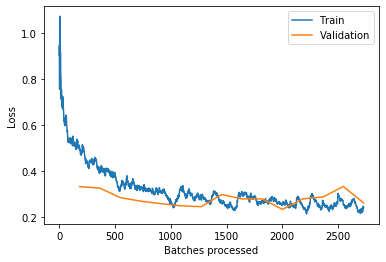

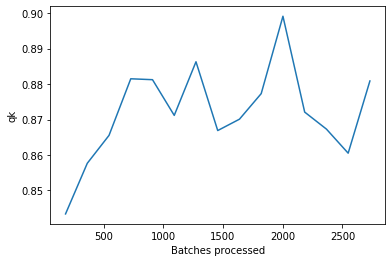

In [21]:
# test
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [28]:
model_save_name = "{}_{}_stage2_f2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 3e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.211574,0.215815,0.891937,00:31
1,0.219235,0.216245,0.890340,00:31
2,0.211067,0.215006,0.891185,00:31
3,0.213285,0.213188,0.888588,00:31
4,0.225545,0.212235,0.889312,00:31
5,0.214128,0.211620,0.888965,00:32
6,0.205695,0.210925,0.890529,00:32
7,0.202283,0.210659,0.889513,00:32
8,0.210698,0.210282,0.889129,00:32
9,0.195430,0.210505,0.889475,00:32


Better model found at epoch 0 with valid_loss value: 0.21581517159938812.
Better model found at epoch 2 with valid_loss value: 0.21500563621520996.
Better model found at epoch 3 with valid_loss value: 0.21318821609020233.
Better model found at epoch 4 with valid_loss value: 0.21223512291908264.
Better model found at epoch 5 with valid_loss value: 0.2116195261478424.
Better model found at epoch 6 with valid_loss value: 0.21092548966407776.
Better model found at epoch 7 with valid_loss value: 0.210658997297287.
Better model found at epoch 8 with valid_loss value: 0.21028238534927368.
Epoch 12: early stopping
Model save as: efficientnet-b4_0820_01-09-57_stage2_f2


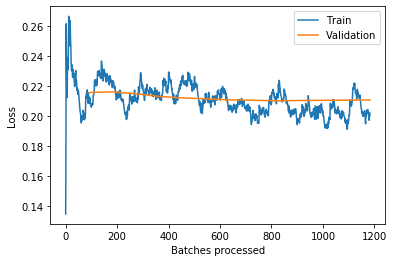

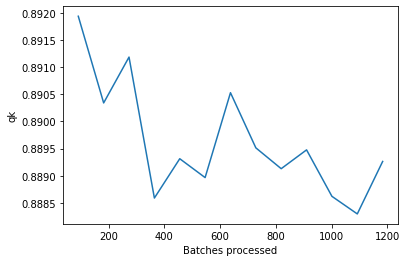

In [29]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [22]:
learn.load(model_save_name);

## Fold 3

In [23]:
# test
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid3")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);   # 原为efficientnet-b4_0811_00-03-47_stage1

Loaded pretrained weights for efficientnet-b4


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 5.25E-04


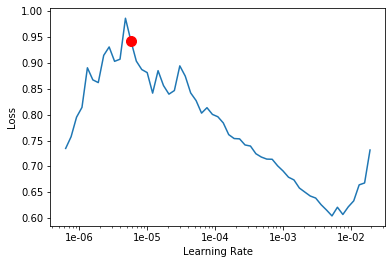

In [24]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find()   # 183轮
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


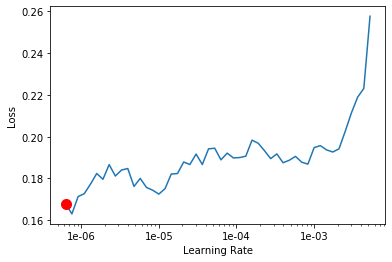

In [71]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [25]:
# test
model_save_name = "{}_{}_stage2_f3".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.446339,0.348549,0.838363,02:08
1,0.370363,0.324014,0.846041,02:09
2,0.373080,0.302368,0.862098,02:09
3,0.287320,0.311277,0.844743,02:09
4,0.279874,0.258261,0.857540,02:09
5,0.268431,0.279506,0.868722,02:09
6,0.287866,0.303173,0.852390,02:08
7,0.311309,0.286299,0.861907,02:09


Better model found at epoch 0 with valid_loss value: 0.3485487401485443.
Better model found at epoch 1 with valid_loss value: 0.32401376962661743.
Better model found at epoch 2 with valid_loss value: 0.3023683428764343.
Better model found at epoch 4 with valid_loss value: 0.2582610845565796.
Epoch 8: early stopping
Model save as: efficientnet-b4_1203_16-38-41_stage2_f3


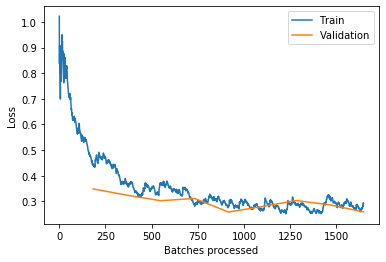

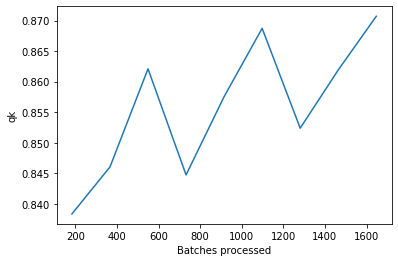

In [26]:
# test
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [72]:
model_save_name = "{}_{}_stage2_f3".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.205838,0.211682,0.889452,00:38
1,0.183874,0.211485,0.889687,00:38
2,0.183006,0.211660,0.889171,00:38
3,0.188817,0.211356,0.888741,00:38
4,0.190335,0.211459,0.889545,00:38
5,0.181748,0.212216,0.890758,00:38
6,0.185391,0.211988,0.889534,00:37


Better model found at epoch 0 with valid_loss value: 0.2116822898387909.
Better model found at epoch 1 with valid_loss value: 0.2114846557378769.
Better model found at epoch 3 with valid_loss value: 0.2113559991121292.
Epoch 7: early stopping
Model save as: efficientnet-b4_0820_01-09-57_stage2_f3


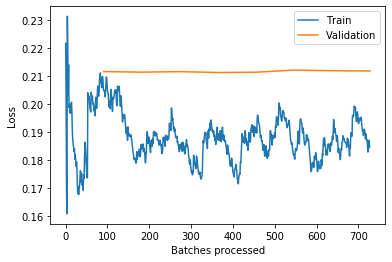

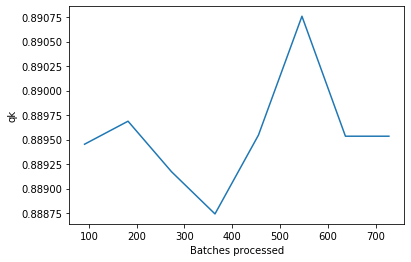

In [73]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [27]:
learn.load(model_save_name);

## Fold 4

In [29]:
# test
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid4")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);

Loaded pretrained weights for efficientnet-b4


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-04


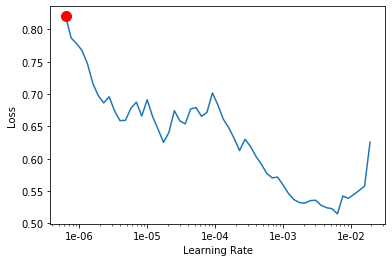

In [30]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 9.12E-08


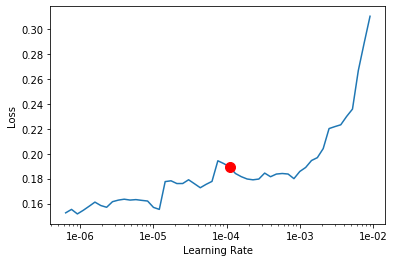

In [52]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [31]:
# test
model_save_name = "{}_{}_stage2_f4".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.484304,0.389623,0.819494,02:12
1,0.408676,0.388576,0.829067,02:13
2,0.335445,0.338737,0.839428,02:13
3,0.342529,0.311833,0.844361,02:12
4,0.284160,0.320966,0.837428,02:14
5,0.284890,0.268685,0.863192,02:12
6,0.284420,0.263377,0.870846,02:13
7,0.282358,0.306963,0.857510,02:13
8,0.283699,0.259183,0.890609,02:10
9,0.255261,0.263961,0.882784,02:09


Better model found at epoch 0 with valid_loss value: 0.38962265849113464.
Better model found at epoch 1 with valid_loss value: 0.38857558369636536.
Better model found at epoch 2 with valid_loss value: 0.3387366235256195.
Better model found at epoch 3 with valid_loss value: 0.3118332326412201.
Better model found at epoch 5 with valid_loss value: 0.26868489384651184.
Better model found at epoch 6 with valid_loss value: 0.2633768320083618.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Better model found at epoch 8 with valid_loss value: 0.25918281078338623.
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Both the predict and ground truth are the same and the only one class! set qk as 1.0
Epoch 12: early stopping
Model save as: efficientnet-b4_1203

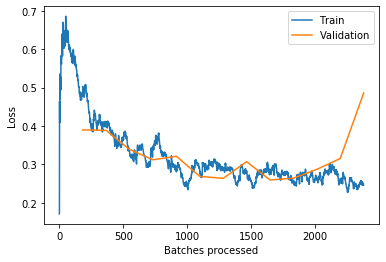

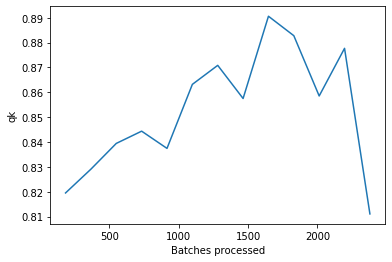

In [32]:
# test
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [53]:
model_save_name = "{}_{}_stage2_f4".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 8e-7, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.181965,0.227602,0.892832,00:33
1,0.182879,0.227511,0.893388,00:36
2,0.192191,0.228532,0.892223,00:36
3,0.199346,0.228449,0.892614,00:35
4,0.201544,0.228810,0.892483,00:36


Better model found at epoch 0 with valid_loss value: 0.2276020497083664.
Better model found at epoch 1 with valid_loss value: 0.22751060128211975.
Epoch 5: early stopping
Model save as: efficientnet-b4_0820_01-09-57_stage2_f4


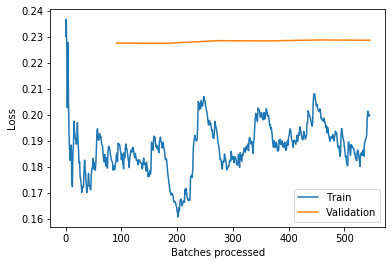

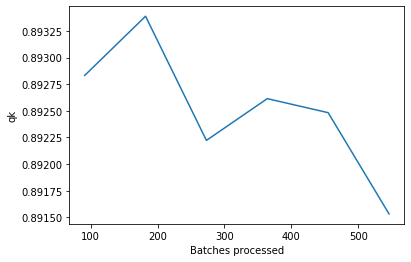

In [54]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [33]:
learn.load(model_save_name);

## Fold 5

In [36]:
# test
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid5")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);

Loaded pretrained weights for efficientnet-b4


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 6.31E-08


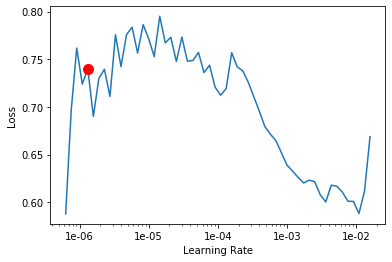

In [37]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 1.58E-05


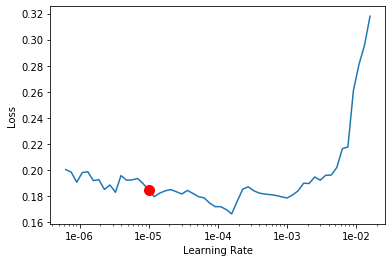

In [16]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [38]:
# test
model_save_name = "{}_{}_stage2_f5".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.505705,0.373187,0.826973,02:08
1,0.407086,0.394694,0.837430,02:08
2,0.330480,0.349416,0.837937,02:08
3,0.307560,0.312160,0.852215,02:08
4,0.292367,0.295860,0.856685,02:08
5,0.266835,0.289622,0.867754,02:10
6,0.258354,0.278992,0.869440,02:09
7,0.271702,0.311062,0.848664,02:09
8,0.282911,0.299651,0.873381,02:09
9,0.253670,0.261128,0.872345,02:10


Better model found at epoch 0 with valid_loss value: 0.37318673729896545.
Better model found at epoch 2 with valid_loss value: 0.3494156002998352.
Better model found at epoch 3 with valid_loss value: 0.312160462141037.
Better model found at epoch 4 with valid_loss value: 0.2958599030971527.
Better model found at epoch 5 with valid_loss value: 0.2896215617656708.
Better model found at epoch 6 with valid_loss value: 0.2789916694164276.
Better model found at epoch 9 with valid_loss value: 0.2611280083656311.
Epoch 13: early stopping
Model save as: efficientnet-b4_1203_16-38-41_stage2_f5


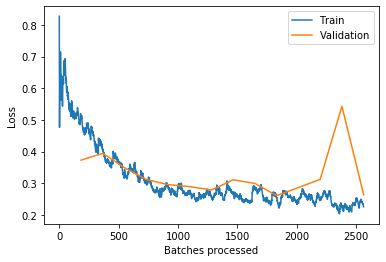

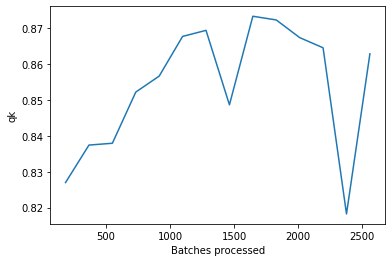

In [39]:
# test
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [13]:
model_save_name = "{}_{}_stage2_f5".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.192591,0.221018,0.893849,00:36
1,0.191610,0.219677,0.892976,00:35
2,0.179460,0.220028,0.894366,00:36
3,0.193376,0.220370,0.892722,00:37
4,0.177385,0.223040,0.889829,00:35


Better model found at epoch 0 with valid_loss value: 0.221018448472023.
Better model found at epoch 1 with valid_loss value: 0.21967662870883942.
Epoch 5: early stopping
Model save as: efficientnet-b4_0821_00-02-25_stage2_f5


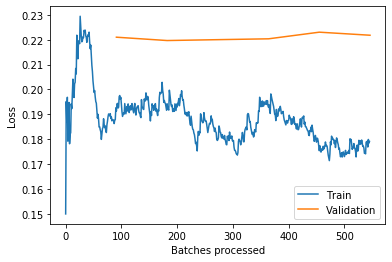

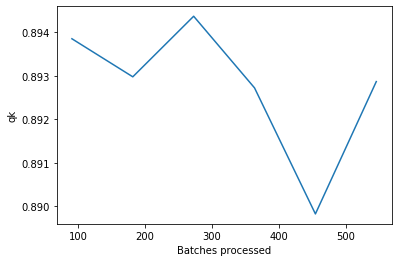

In [14]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [40]:
learn.load(model_save_name);

## Retrain on whole dataset

In [8]:
# test
# 在整个集上进行训练，注意没有划分验证集，训练过程中输出的valid_loss为#na#
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_none()
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load(base_model_name);

Loaded pretrained weights for efficientnet-b4


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.58E-03


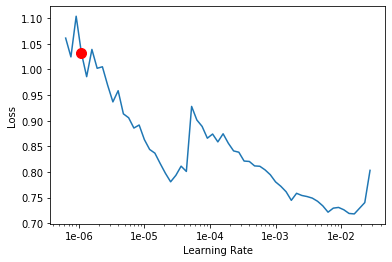

In [9]:
# test
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [10]:
# test
model_save_name = "{}_{}_stage2_whole".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

Model save as: efficientnet-b4_1203_16-38-41_stage2_whole


In [11]:
# test
model_save_name = "{}_{}_stage2_whole".format(model_name, current_time)
learn.fit_one_cycle(4, 2e-4)

In [12]:
# test
learn.fit_one_cycle(4, 2e-5)

In [19]:
model_save_name = "{}_{}_stage2_whole".format(model_name, current_time)
learn.fit_one_cycle(4, 2e-4)

Loaded pretrained weights for efficientnet-b4


In [27]:
learn.fit_one_cycle(1, 2e-5)

In [14]:
learn.export("../output/inference/{}.pkl".format(model_save_name))

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [15]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Submission

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d7316198>]], dtype=object)

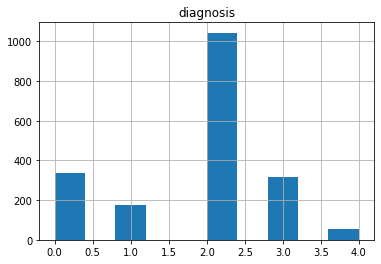

In [11]:
old = pd.read_csv("b4_808.csv")
old.hist()

## Fold 1

efficientnet-b4_0820_01-09-57_stage2_f1_submition.csv done


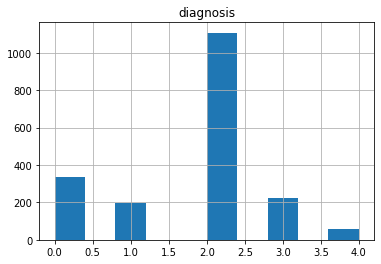

0.94316920054558

In [21]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 2

efficientnet-b4_0820_01-09-57_stage2_f2_submition.csv done


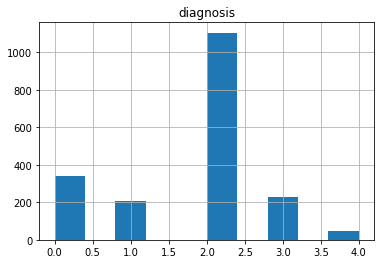

0.9568021553408323

In [32]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 3

efficientnet-b4_0820_01-09-57_stage2_f3_submition.csv done


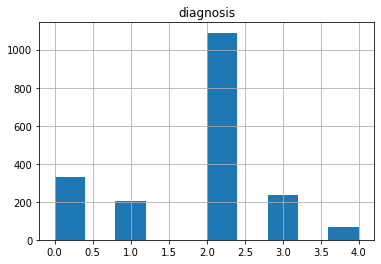

0.9484118664175546

In [75]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 4

efficientnet-b4_0820_01-09-57_stage2_f4_submition.csv done


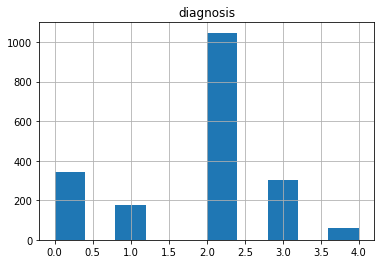

0.9373205886043715

In [56]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 5

efficientnet-b4_0821_00-02-25_stage2_f5_submition.csv done


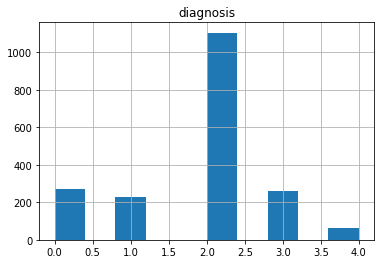

0.927556516809854

In [21]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Whole Data

efficientnet-b4_0823_18-14-19_stage2_whole_submition.csv done


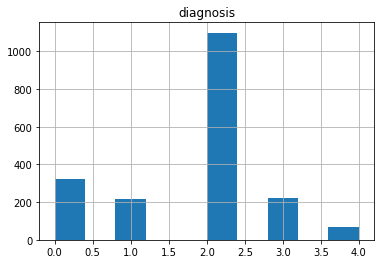

0.9471472160819255

In [29]:
# epoch = 7
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)